In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os 
import copy as cp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from numba import jit
import csv
import numpy
import PIL

# Objectif : créer les masques dans des dossiers séparés à partir des fichiers csv

### PATHS and DIRECTORIES

In [2]:
# get local variables
local_path = os.getcwd()
data_path = os.path.join(local_path,'data/')

# data directories
train_dir = os.path.join(data_path,'train_images/')
validation_dir = os.path.join(data_path,'validation_images/')

# csv files 
train_csv = os.path.join(data_path,'train.csv')
validation_csv = os.path.join(data_path,'validation.csv')

# mask directories
masks_train_dir = os.path.join(data_path,'train_masks/')
masks_validation_dir = os.path.join(data_path,'validation_masks/')

### Fonctions de conversion

In [3]:
## Read and save CSV
def CSV_to_descriptions(csv_path): # dictionnary with names and captions of images
    'convert csv train and test files into usable dictionnary'

    # first dictionnary 
    descriptions_dict = {}
    
    #open training file
    with open(csv_path,'r') as csvfile:
        # split by ,
        file_reader = csv.reader(csvfile,delimiter=',',)

        #ignore first entry
        iter_file_reader = iter(file_reader)
        next(iter_file_reader)

        # 4 types of fdefects 
        compteur = 0

        # fill in dictionnary with all captions
        for row in iter_file_reader:
            # extract image id
            img_name = row[0].split('_')[0]
            img_name = img_name.split('.')[0]

            # create empty list
            if (compteur%4==0):
                descriptions_dict[img_name] = []

            # add caption
            caption = row[1]
            descriptions_dict[img_name].append(caption)

            # update compteur
            compteur +=1
        #iterate over images
    for img_name in descriptions_dict.keys():

        ## start converting captions to list of integres

        # get raw data
        caption_list = cp.copy(descriptions_dict[img_name])

        # defect number
        count = 0

        #iterate of defects type
        for string in caption_list:
            # convert string to list of integers
            if (caption_list[count] == ''):
                caption_list[count] = []
            else:

                # convert to integer
                caption_list[count] = string.split(' ')
                caption_list[count] = [int(number) for number in caption_list[count]]

                # delete 1 on all indices to match python indices
                for i in range(0,len(caption_list[count]),2):
                    caption_list[count][i] += -1
                    
            #update dictionnary
            descriptions_dict[img_name] = caption_list
            
            #update count
            count+=1
    return descriptions_dict

### If all images are not the same size the program will crash, let us check if everything is all right !

In [4]:
def check_image_size(descriptions_dict,DIR):
    'check if all images are the same size'
    #compteur image
    compteur = 0

    #iterate over img names
    for img_name in descriptions_dict.keys():
        # update image number
        compteur +=1

        # convert image to array
        img_path = os.path.join(DIR,img_name+'.jpg')
        img = PIL.Image.open(img_path).convert("L")
        imgarr = numpy.array(img)

        # verification
        if (imgarr.shape != (256,1600)):
            print('Problème with '+ img_name)
            print(imgarr.shape)

    # retourner le nombre d'image, expected 12568
    print(compteur)

### Maintenant on assemble

In [5]:
# On créer les dictionnaires importants
train_descriptions = CSV_to_descriptions(train_csv)
validation_descriptions = CSV_to_descriptions(validation_csv)
check_image_size(train_descriptions,train_dir)
check_image_size(validation_descriptions,validation_dir)

12568
1801


# Creation des masques 

In [6]:
def description_to_image(img_name,descriptions_dict,img_directory_path = "",plot_image = False):
    'convert segmentation in csv file into numpy image'
    
    #image_size
    img_size = (256,1600)

    #initialize final list, 0 is the default value
    image = np.zeros(img_size)
    
    #take values
    caption_list = cp.deepcopy(descriptions_dict[img_name])
    ## fill in the list from top to bottom, and left to right
    #iterate on defects type
    for defect_number in range(4):
        #iterate on the lists of defects
        for compteur,value in enumerate(caption_list[defect_number]):
            # if pair : pixel, else : length
            if (compteur%2==0):
                # on remplis tous les autres jusqu'a defect size:
                for compteur2 in range(caption_list[defect_number][compteur+1]):
                    #take position of the pixel
                    current_state = value-1+compteur2
                    
                    #convert into row and column (top to bottom and left to right)
                    row = current_state%img_size[0]
                    column = current_state//img_size[0]
                    
                    # add defect number
                    image[row][column]=defect_number+1
    
                    
    #plot both of the images
    if(plot_image):
        array = image
        print(array.max())
        plt.imshow(array)
        plt.show()
        img = mpimg.imread(os.path.join(img_directory_path,img_name+'.jpg'))
        plt.imshow(img)
        print(img.shape)
        plt.show()
    else:
        return image

4e2e1bdb7
3.0


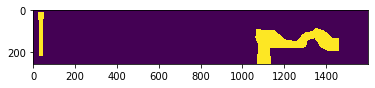

(256, 1600, 3)


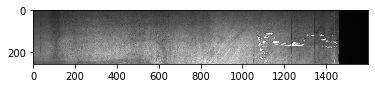

In [15]:
##plot random images with their segmentations

# select random image
img_number = random.randint(0,len(train_descriptions.keys())-1)
img_name = list(train_descriptions.keys())[img_number]
print(img_name)
#img = mpimg.imread(os.path.join(TRAINING_DIR,img_name))
#plot image
description_to_image(img_name,train_descriptions,train_dir,True)

Un rapide calcul nous montre qu'il est impossible de charger en mémoire toutes les images. En effet, bien qu'elles soient toutes compréssée pour tenir dans 2.5Go, les outputs, mêmes codés en 8 bits, prendraient 15 Go de mémoire vive. On va donc se contenter de créer une fonction qui retourne un vecteur avec un mask. 


In [23]:
# ecriture des masks en mémoire
def image_to_mask(description_dict,img_name):
    'return a 256*1600*4 numpy array'

    #initialize final list, 0 is the default value
    image = np.zeros(256*1600*4)
    
    #take values
    caption_list = cp.deepcopy(descriptions_dict[img_name])
    ## fill in the list from top to bottom, and left to right
    #iterate on defects type
    for defect_number in range(4):
        #iterate on the lists of defects
        for compteur,value in enumerate(caption_list[defect_number]):
            # if pair : pixel, else : length
            if (compteur%2==0):
                # on remplis tous les autres jusqu'a defect size:
                for compteur2 in range(caption_list[defect_number][compteur+1]):
                    #take position of the pixel
                    current_state = value-1+compteur2
                    
                    #convert into row and column (top to bottom and left to right)
                    row = current_state%img_size[0]
                    column = current_state//img_size[0]
                    
                    # add defect number
                    image[row][column][defect_number]=1
    return image